In [1]:
%pip install --quiet mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import collections

In [3]:
# returns the percent of each status
def percInf(model):
  return (sum(1 for agent in model.schedule.agents if agent.state == 1)) / len(model.schedule.agents)

def percSus(model):
  return (sum(1 for agent in model.schedule.agents if agent.state == 0)) / len(model.schedule.agents)

def percDead(model):
  return (sum(1 for agent in model.schedule.agents if agent.state == 2)) / len(model.schedule.agents)

class Agent(mesa.Agent):
  # state, recovery time, and time infected
  def __init__(self, unique_id, model, recTime):
    super().__init__(unique_id, model)
    self.state = 0
    self.recTime = recTime
    self.infTime = 0

  def step(self):
    self.updateState()
    self.move()
    self.infect()



  def updateState(self):
    # if agent is infected, check if dies, and then check if has recovered from time if alive
    if self.state == 1:
      alive = np.random.choice([0,1], p=[self.model.drate, 1-self.model.drate])
      if alive == 0:
        self.state = 2
      self.infTime += 1
      if self.infTime >= self.recTime:
        self.state = 0
        self.infTime = 0

  def move(self):
    # if agent is alive, moves to random part of neighborhood
    if (self.state != 2):
      possible_steps = self.model.grid.get_neighborhood(
          self.pos, moore = True, include_center = False
      )
      new_position = self.random.choice(possible_steps)
      self.model.grid.move_agent(self, new_position)

  def infect(self):
    # iterates through neighbors, infecting them based on percentage given
    neighbors = self.model.grid.get_neighbors(self.pos, moore = True, radius = 1, include_center = False)
    if self.state == 1:
      for agent in neighbors:
        infect = np.random.choice([0,1], p=[self.model.probInf,1- self.model.probInf])
        if agent.state == 0 and infect == 0:
          agent.state = 1



class Model(mesa.Model):
  # grid dimensions, number of agents, probability of infection, recovery time, death rate, starting amount of infected
  def __init__(self, N, width, height, probInf, recTime, deathRate, startingInf):
    self.numAgents = N
    self.recTime = recTime
    self.probInf = probInf
    self.drate = deathRate
    self.grid = mesa.space.MultiGrid(width,height, True)
    self.schedule = mesa.time.RandomActivation(self)
    self.numdead = 0
    self.running = True


    #generate grid of agents in random positions

    for i in range(self.numAgents):
      agent = Agent(i, self, self.recTime)
      if i < startingInf:
        agent.state = 1
      self.schedule.add(agent)
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)
      self.grid.place_agent(agent, (x,y))
    # keep track of sum of each status, and status of agents
    self.datacollector = mesa.DataCollector(
        model_reporters = {"Susceptible": percSus,"Infected": percInf,"Dead": percDead},
        agent_reporters = {"State": "state"},
    )

  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()





In [4]:
model = Model(100, 10, 10, .3, 4, .5, 5)
for i in range(50):
  model.step()

In [5]:
states = model.datacollector.get_agent_vars_dataframe()
states.tail()

State
Step AgentID       
49   95           2
     96           0
     97           2
     98           2
     99           2

In [6]:
data= states.groupby(['Step', 'State']).size().reset_index(name = 'Count')
data = data.pivot(index = 'Step', columns = ['State'], values = 'Count').reset_index(drop = True).fillna(0)
data.columns = ['Susceptible', 'Infected', 'Dead']
data.head()

,Susceptible,Infected,Dead
0,95.0,5.0,0.0
1,80.0,16.0,4.0
2,60.0,24.0,16.0
3,42.0,33.0,25.0
4,27.0,31.0,42.0


[Text(0.5, 1.0, 'States of Population'),
 Text(0, 0.5, 'Num Infected'),
 Text(0.5, 0, 'Steps')]

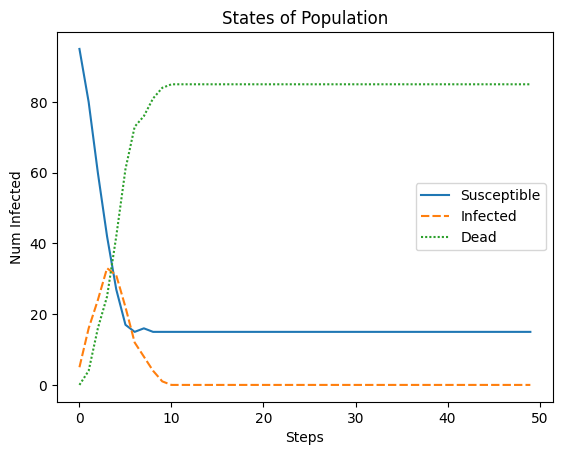

In [7]:
g = sns.lineplot(data = data)
g.set(title = "States of Population", ylabel = "Num Infected", xlabel = "Steps")

In [8]:
from mesa.experimental import JupyterViz
from matplotlib.figure import Figure
import solara

def agent_portrayal(agent):
    size = 50
    color = "tab:red"
    layer = 0
    return {"size": size, "color": color, "layer": layer}

model_params = {
    "N": {
        "type": "SliderInt",
        "value": 100,
        "label": "Number of Agents",
        "min": 10,
        "max": 200,
        "step": 1
    },
    "width": {
        "type": "SliderInt",
        "value": 25,
        "label": "Width",
        "min": 1,
        "max": 50,
        "step": 1
    },
    "height": {
        "type": "SliderInt",
        "value": 25,
        "label": "Height",
        "min": 1,
        "max": 50,
        "step": 1
    },
    "probInf" : {
        "type" : "SliderFloat",
        "value": .65,
        "label": "Infection Probability",
        "min": 0.1,
        "max": 1,
        "step": 0.1
    },
    "deathRate" : {
        "type" : "SliderFloat",
        "value": .3,
        "label": "Death Probability per Step",
        "min": 0.1,
        "max": 1,
        "step": 0.1
    },
    "startingInf" : {
        "type" : "SliderInt",
        "value": 15,
        "label": "Starting Amount of Infected Agents",
        "min": 0,
        "max": 100,
        "step": 1
    },
    "recTime" : {
        "type" : "SliderInt",
        "value": 5,
        "label": "Recovery Time (Steps)",
        "min": 0,
        "max": 10,
        "step": 1
    },
}

"""
def make_lineplot(model):
  fig = Figure()
  ax = fig.subplots()
  sus = len([agent for agent in model.schedule.agents if agent.state == 0])
  inf = len([agent for agent in model.schedule.agents if agent.state == 1])
  dead = len([agent for agent in model.schedule.agents if agent.state == 2])
  ax.plot(model.schedule.steps, sus, label='Susceptible', color = 'Blue')
  ax.plot(model.schedule.steps, inf, label='Infected', color = 'Red')
  ax.plot(model.schedule.steps, dead, label='Dead', color = 'Black')
  ax.set_title("Status Distribution Over Time")
  ax.set_xlabel("Step")
  ax.set_ylabel("Number of Agents")
  ax.legend()
  solara.FigureMatplotlib(fig)
"""

page = JupyterViz(
    Model,
    model_params,
    measures = ["Susceptible", "Infected", "Dead"],
    name = "Infection Model",
    agent_portrayal = agent_portrayal

)
page

Html(layout=None, style_='display: none', tag='span')

Cannot show ipywidgets in text